## Implementation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Read the CSV

In [ ]:
df = pd.read_csv('ebay_reviews.csv')
df.head()

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5


## Text Cleaning

### Drop NA values
Because we do not want to work with the empty reviews or empty category tags.

In [ ]:
df = df.dropna()
print(f'Dataset number of column: {df.shape[1]}, and number of row: {df.shape[0]}')

Dataset number of column: 4, and number of row: 44754


### Remove punctions, extra space and convert words to lower case

In [ ]:
def clean_text(text):
    # convert to lover case and remove extra space.
    text = text.lower().strip()
    # this is for html tagging if they have.
    text = re.sub(r'<.*?>', '', text)
    # this is for punctuation.
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['cleaned_content'] = df['review content'].apply(clean_text)

## Data Pre-processing

### Remove Stop Words and Transformer to stem words.
**Removed stop words** using nltk library. It removes common English words that do not add much value to the meaning of the text. This helps to improve processing time.

**Transform Stemmer** using nltk library. It changes words to their base or root forms.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['cleaned_content'] = df['cleaned_content'].apply(preprocess_text)
df[['review content', 'cleaned_content']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review content,cleaned_content
0,This gaming headset ticks all the boxes # look...,game headset tick box look grate built last ex...
1,"Easy setup, rated for 6 hours battery but mine...",easi setup rate hour batteri mine last session...
2,I originally bought this wireless headset for ...,origin bought wireless headset xbox latest mod...
3,"This is my 2nd Mezumi headset, It kills the fi...",nd mezumi headset kill first one better rang l...
4,This is probably the best headset I've purchas...,probabl best headset ive purchas till date sou...


### Transform Rating Target Column
For the traditional models; transformed rating column into 3 different categories. (negative, neutral, positive)

In [ ]:
df['rating'].unique()

array([5, 3, 4, 2, 1])

In [ ]:
df['rating_categorical'] = df['rating'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
df[['rating', 'rating_categorical']].head()

,rating,rating_categorical
0,5,positive
1,3,neutral
2,5,positive
3,5,positive
4,5,positive


### Split the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_content'], df['rating_categorical'], test_size=0.2, random_state=0)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (35803,)
y_train shape: (35803,)
X_test shape: (8951,)
y_test shape: (8951,)


## Model Selection and Training


### Train Traditional Models
Train **Logistic Regression** and **Multinomial Naive Bayes** models using pipeline method from sklearn. It allows to sequentially apply the steps.

In pipeline sequence; First it'll apply **TF-IDF vectorizer** then the machine learning model.

Because the machine learning algorithm won't understand the text, the TF-IDF vectorizer is used. With the help of this, the text data will be converted into a numerical representation.

 Target labels are categorical. Thus, Logistic regression and Naive Bayes, classification algorithms, were used.


In [ ]:
pipeline_lg = Pipeline([
    ('Tfid_vectorizer', TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=5000)),
    ('classifier', LogisticRegression())
])

pipeline_lg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('Tfid_vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('classifier', LogisticRegression())])

In [ ]:
pipeline_nb = Pipeline([
    ('Tfid_vectorizer', TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=5000)),
    ('classifier', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('Tfid_vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('classifier', MultinomialNB())])

###Evaluate the model
Logistic Regression Model Accuracy: 0.93

Multinomial Naive Bayes Model Accuracy:0.92

In [ ]:
accuracyLG = pipeline_lg.score(X_test, y_test)
print(f'Logistic Regression Model accuracy: {accuracyLG}')

accuracyNB = pipeline_nb.score(X_test, y_test)
print(f'Multinomial Naive Bayes Model accuracy: {accuracyNB}')

Logistic Regression Model accuracy: 0.936543402971735
Multinomial Naive Bayes Model accuracy: 0.9276058540945146


### Train a Deep Neural Network

Preprocess of the **Deep Neural Network**;
- Transformed rating column into three numerical representings. (0=negative, 1=neutral, 2=positive)

- Tokenized and padded sequences. Those padded sequences and labels that are numerical used for train test split.



In [ ]:
df['rating_numerical'] = df['rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))
df[['rating', 'rating_numerical']].head()
labels = to_categorical(df['rating_numerical'])

**Tokenize and pad sequences**

This step is to transform raw text data into a structured format suitable for feeding into an LSTM model. It will improve the model's ability to learn from meaningful patterns.


texts_to_sequences converts each review in the cleaned_review column to a sequence of integers.


In [ ]:
# num_words=5000 -> the top 5000 most frequent words in the dataset.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])

sequences = tokenizer.texts_to_sequences(df['cleaned_content'])

# maxlen=100 -> This sets the maximum length of all sequences.
# Sequences longer than 100 words will be truncated, and shorter will be padded.
# post-padding and post-truncating
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# train test split with 0.2 test size 0.8 train size.
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (35803, 100)
y_train shape: (35803, 3)
X_test shape: (8951, 100)
y_test shape: (8951, 3)


**Define the model**

The purpose of this pipeline is to do sentiment analysis. To be able to do it  I build the following optimal deep learning model.

The optimal model contains;
5 layers. Those are Embedding, LSTM, Dropout, LSTM, Dense layers.

- **Embedding layer** helps in capturing the semantic meaning of words and reduce the dimensionality of the input.

- **LSTM layer** are effective at capturing long-term dependencies in sequence data, which is important for understanding context in text.

- **Dropout layer** and **Dense layer** are common layers when building deep learning model.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=100),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Fit the model

*validation_split=0.2* will automatically split the training data into training and validation sets.

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
896/896 [==============================] - 137s 148ms/step - loss: 0.3155 - accuracy: 0.9274 - val_loss: 0.3353 - val_accuracy: 0.9203
Epoch 2/10
896/896 [==============================] - 127s 142ms/step - loss: 0.3081 - accuracy: 0.9281 - val_loss: 0.3334 - val_accuracy: 0.9203
Epoch 3/10
896/896 [==============================] - 128s 143ms/step - loss: 0.3056 - accuracy: 0.9284 - val_loss: 0.3348 - val_accuracy: 0.9197
Epoch 4/10
896/896 [==============================] - 112s 124ms/step - loss: 0.3044 - accuracy: 0.9288 - val_loss: 0.3330 - val_accuracy: 0.9203
Epoch 5/10
896/896 [==============================] - 111s 124ms/step - loss: 0.3034 - accuracy: 0.9293 - val_loss: 0.3338 - val_accuracy: 0.9200
Epoch 6/10
896/896 [==============================] - 107s 119ms/step - loss: 0.3016 - accuracy: 0.9295 - val_loss: 0.3324 - val_accuracy: 0.9197
Epoch 7/10
896/896 [==============================] - 108s 121ms/step - loss: 0.2882 - accuracy: 0.9291 - val_loss: 0.3185 -

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Deep Learning model Accuracy: {accuracy}')

280/280 [==============================] - 9s 32ms/step - loss: 0.2447 - accuracy: 0.9297
Deep Learning model Accuracy: 0.9297285079956055


### Deployment

The optimal model from my experiments is the **Logistic regression** model with accuracy 0.93

Thus, for deployment process I used that model to predict and show the result.

In [ ]:
df['predicted_sentiment'] = pipeline_lg.predict(df['cleaned_content'])

# Picked first 5 categories to easily analyse it
first_5_categories = df['category'].value_counts().index[:5]
df_filtered = df[df['category'].isin(first_5_categories)]

# The sentiment by category and rating
category_rating = df_filtered.groupby(['category', 'rating', 'predicted_sentiment']).size().unstack(fill_value=0)

**Plot the sentiment distribution by category and rating**

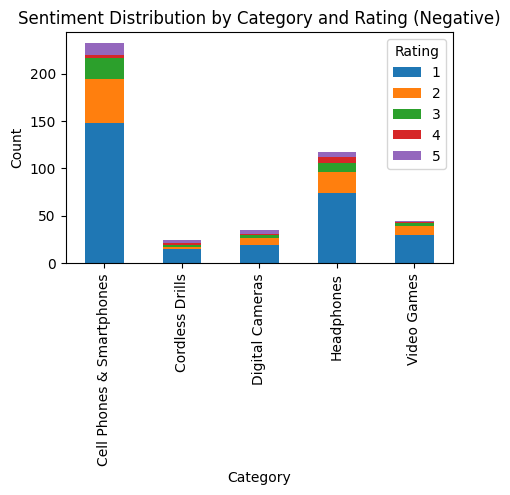

In [ ]:
# Negative sentiments
pivot_negative = category_rating.reset_index().pivot(index='category', columns='rating', values='negative')
pivot_negative.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.title('Sentiment Distribution by Category and Rating (Negative)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Rating')
plt.show()

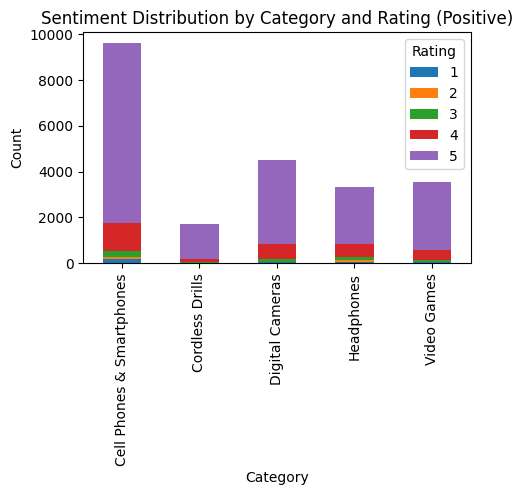

In [ ]:
# Positive sentiments
pivot_positive = category_rating.reset_index().pivot(index='category', columns='rating', values='positive')
pivot_positive.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.title('Sentiment Distribution by Category and Rating (Positive)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Rating')
plt.show()

As can be seen from the plots above, the ratings given by customers are not completely reliable. They may give one point but leave a positive comment, and vice versa.

Since it is separated by categories, you can see in which category the company has the most negative comments and, if necessary, the content of the comment. and can draw an action plan accordingly. For example, cell phones and smartphones have more negative comments than other categories that are shown in the plot.

## Overall Discussion

**Strenghts**

- The model is trained on real-world data.

- Reviews contain a three types of opinions (positive, negative, neutral) that likely help produce a more nuanced model.


**Limitations**

- User reviews can contain typos, slang etc., which can complicate the pipeline.

- Sentiment analysis can be highly context-dependent. Different contexts can refer to different sentiments.

- Customer ratings may not be reliable.

**Implications**

- It can help eBay identify product strengths and weaknesses from customer sentiment analysis. Negative reviews may highlight areas for improvement in products or customer service.

**Data-driven Recommendations**

- Reviews can be used in marketing campaigns.

- The range of product categories can be expanded to integrate with all of eBay's products.

